# Буранов М.М. 

# Изучение пользователей Яндекс Афиши

## Введение

В данной работе нам предстоит изучить статистику с сайта Яндекс Афиши с июня 2017 по конец мая 2018 года. Используя эти данные мы должны сделать выводы о том, как клиенты пользуются сервисом, когда делают первые покупки на сайте, сколько денег приносит компании каждый клиент, в какой момент расходы на привлечение клиентов окупаются. 

Чтобы изучить то, как клиенты пользуется сервисом мы будем использовать следующие продуктовые метрики - DAU, WAU, MAU, Retention Rate. 

Для подсчёта метрик электронной коммерции мы будем использовать LTV и подсчитаем средний чек покупок. 

Маркетинговую эффективность мы подсчитаем с помощью CAC и ROMI. 

В наших руках 3 датасета, которые помогут нам выполнить необходимый анализ: 
 - лог сервера с данными о посещениях сайта Яндекс.Афиши (содержит данные о типе устройства пользователя, начале и конце сессии, идентификаторе источника и уникальном номере пользователя;
 - выгрузка всех заказов за этот период, статистика рекламных расходов (время покупки, сумма заказа, уникальный номер пользователя);
 - статистика рекламных расходов (рекламный источник, дата рекламной кампании, расходы на кампанию);

В ходе исследования мы должны определить источник трафика, на который маркетологам следует делать особый упор, и выявить самые перспективные когорты клиентов. 

## Изучение данных из файла

Импортируем библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from scipy import stats as st
warnings.simplefilter('ignore')

Сохраняем датасеты в переменные.

In [2]:
visits = pd.read_csv('https://#####.csv')
orders = pd.read_csv('https://#####.csv')
costs = pd.read_csv('https://#####.csv')

Изучим датафреймы. Заодно проверим типы данных. 

In [3]:
visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.sample(5)

,Buy Ts,Revenue,Uid
8262,2017-09-19 15:00:00,2.81,3644482766749211722
35075,2018-02-15 17:37:00,1.53,11593110015598634188
14177,2017-10-23 15:12:00,6.05,8978325978273575584
9442,2017-09-28 12:14:00,1.47,7450601897884192115
19887,2017-11-25 00:41:00,0.06,7280867604594257671


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
costs.tail()

,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Пропусков в данных нет. Необходимо изменить только типы данных в столбиках с датами и название столбцов. 

## Изменение типов данных 

В названиях столбцов заменим пробелы на нижнее подчёркивание и приведём всё к нижнему регистру.

In [9]:
visits.columns = visits.columns.str.replace(' ', '_').str.lower()
orders.columns = orders.columns.str.replace(' ', '_').str.lower()
costs.columns = costs.columns.str.replace(' ', '_').str.lower()

Изменим типы данных в столбиках с датами. Даты сократим до дня - это минимальное, что требуется для анализа. 

In [10]:
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
costs['dt'] = costs['dt'].astype('datetime64[D]')

In [11]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [12]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

В таблицу с заказами попала лишняя дата - 1 июня 2018. Исключим её из анализа.

In [13]:
orders = orders[orders['buy_ts']<'2018-06-01']

In [14]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Тип данных изменен.  Можно приступать к анализу. 

## Рассчёт продуктовых метрик

### Рассчитаем DAU, WAU и MAU

Для этого используем таблицу visits. 
Создадим колонки с неделями и месяцами.

In [15]:
visits['activity_day'] = visits['start_ts'].astype('datetime64[D]')
visits['activity_week'] = (
    visits['activity_day'] 
    - pd.to_timedelta(visits['activity_day'].dt.dayofweek, unit='d')
)
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

Составим функцию для определения активности пользователей за необходимый временой промежуток.

In [16]:
def active_users (column):
    au = visits.groupby(column).agg({'uid':'nunique'})
    mean = au['uid'].mean().round(2)
    print('Среднее значение за весь период', mean)
    print()
    au.plot(kind = 'line', figsize = (12,8))
    plt.title('Распределение во времени')
    plt.show()

#### Дневная активность пользователей

Среднее значение за весь период 907.99



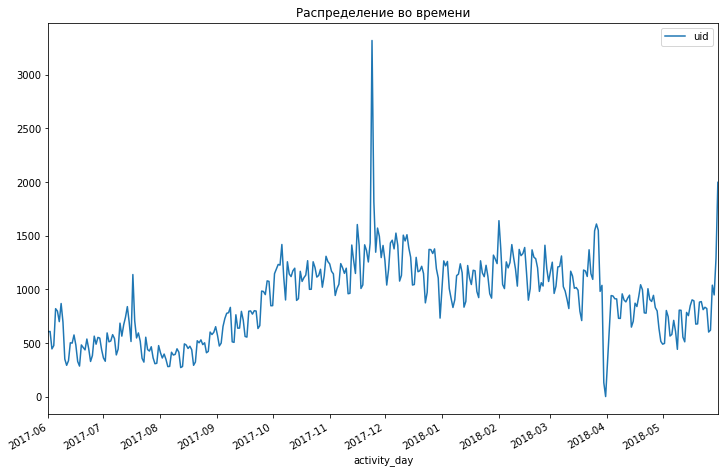

In [17]:
active_users('activity_day')

На графике заметны несколько выбросов - в конце ноября и в конце мая всплески активности, в конце марта резкий дневной спад. Высокую пиковую активность можно объяснить днями открытия продаж на популярные мероприятия, где надо поторопиться, чтобы успеть купить билеты.  

Спад скорее всего связан с неполадками на стороне сервиса. 

Заметна зависимость графика от сезонности - летом сервис посещают реже, чем в остальные времена года, а пик приходится на зиму. 

Также можно увидеть зависимость посещаемости сервиса от дней недели.

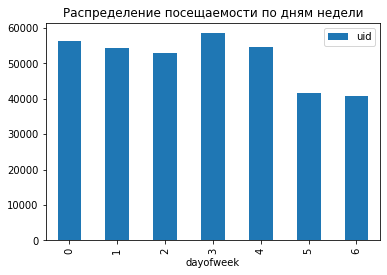

In [18]:
visits['dayofweek'] = visits['activity_day'].dt.dayofweek
visits.groupby('dayofweek').agg({'uid':'count'}).plot(kind='bar')
plt.title('Распределение посещаемости по дням недели')
plt.show()

Видим, что в выходные посещаемость сервисом ниже. Чаще всего заходят на сервис в четверг, видимо чтобы придумать что-нибудь к выходным. 

#### Активность пользователей по неделям

Среднее значение за весь период 5716.25



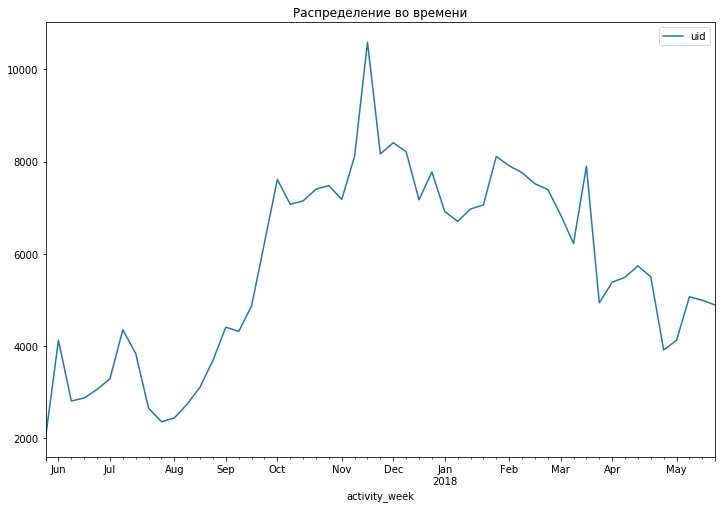

In [19]:
active_users('activity_week')

На этом графике более чётко видны пики посещаемости. Необходимо изучить, на какие мероприятия люди так активно покупали илеты в эти даты, либо какие маркетинговые активности проходили. 

#### Активность пользователей по месяцам

Среднее значение за весь период 23228.42



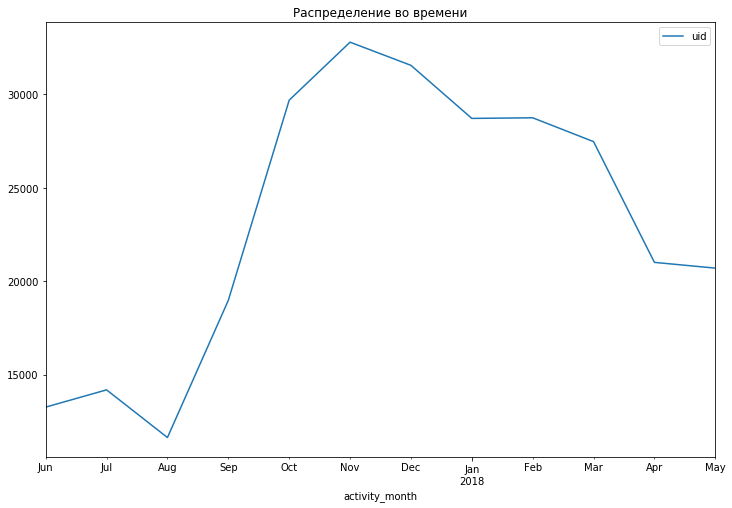

In [20]:
active_users('activity_month')

На графике видим резкий рост посещаемости сервиса в августе, и спад в марте. Это говорит нам о сезонности - в тёплое время года люди меньше интересуются концертами и выставками.  

#### Sticky factor

In [21]:
sticky_factor_wau = 907.99/5716.25
print('Sticky_factor для дней к неделе {:.2%}'.format(sticky_factor_wau))
print()
sticky_factor_dau = 907.99/23228.42
print('Sticky_factor для дней к месяцу {:.2%}'.format(sticky_factor_dau))

Sticky_factor для дней к неделе 15.88%

Sticky_factor для дней к месяцу 3.91%


Sticky_factor низкий, лишь малая часть пользователей пользуется сервисом регулярно. Это скорее связано с особенностью сервиса - люди разово заходят туда, чтобы запланировать выходные и приобрести билеты. 

### Средняя посещаемость сайта

####  Средняя посещаемость в год


В среднем один пользователь заходит на сайт 1.08 раз в день



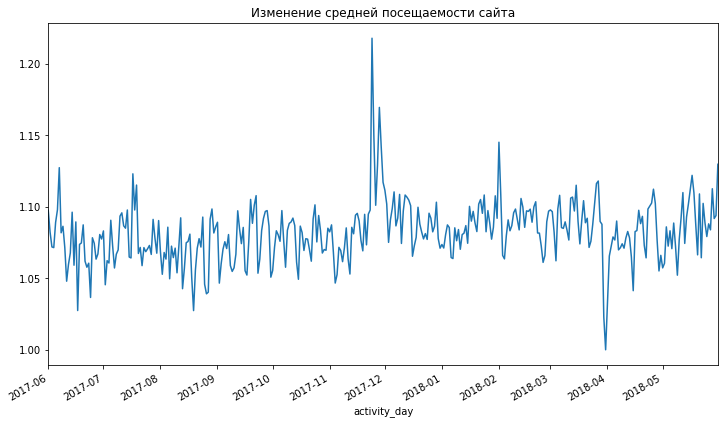

In [22]:
visits_per_user = visits.groupby('activity_day').agg({'uid':['count','nunique']})
visits_per_user.columns = ['n_visits','n_users']
visits_per_user['visits_per_user'] = visits_per_user['n_visits']/visits_per_user['n_users']

print()
print('В среднем один пользователь заходит на сайт {:.2f}'.format(visits_per_user['visits_per_user'].mean()), 'раз в день')
print()

plt.title('Изменение средней посещаемости сайта')
visits_per_user['visits_per_user'].plot(kind='line', figsize = (12,7))
plt.show()


В среднем пользователи заходят на сайт один раз в день. Зашли, выбрали мероприятие, купили, вышли. За наблюдаемый период этот показатель не изменился. Можно отметить только всплески активности, которые совпадают с датами пиковой посещаемости сайта. Возможно в эти дни открывалась продажа на очень крутые концерты и люди с нетерпением ждали, когда уже смогут приобрести билет, обновляя страницу и заходя снова и снова. 

#### Средняя посещаемость в месяц

In [23]:
visits_per_user_month = visits.groupby('activity_month').agg({'uid':['count','nunique']})
visits_per_user_month.columns = ['n_visits','n_users']
visits_per_user_month['visits_per_user'] = visits_per_user['n_visits']/visits_per_user['n_users']

print()
print('В среднем один пользователь заходит на сайт {:.2f}'.format(visits_per_user_month['visits_per_user'].mean()), 'раз в месяц')


В среднем один пользователь заходит на сайт 1.09 раз в месяц


В месяц пользователь заходи на Яндекс Афишу тоже только 1 раз. Видимо концерты каждые выходные это слишком. 

#### Расчёт продолжительности сессий 


Средняя продолжительность сессии: 11.00 мин

Мода распределения сессий: 1.00 мин


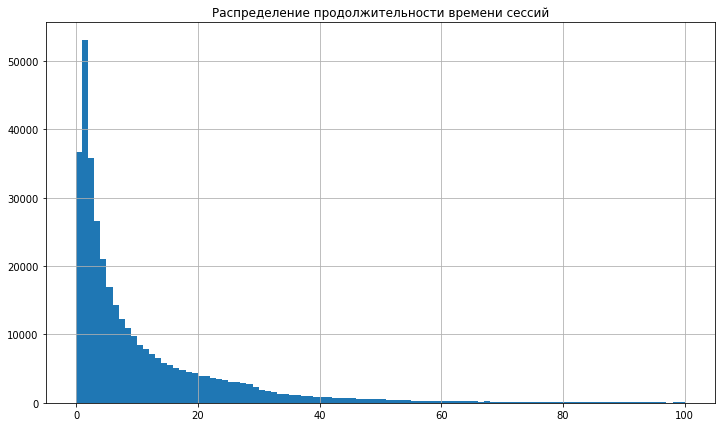

In [24]:
visits['session_duration'] = (visits['end_ts']-visits['start_ts'])/ np.timedelta64(1, 'm')

print()
print('Средняя продолжительность сессии: {:.2f}'.format(visits['session_duration'].mean().round()),'мин')

mode = visits['session_duration'].mode().loc[0]
print()
print('Мода распределения сессий: {:.2f}'.format(mode),'мин')

plt.title('Распределение продолжительности времени сессий')
visits['session_duration'].hist(range=(0,100), figsize = (12,7), bins=100)
plt.show()

ASL равна 11 минутам, однако распределение не нормальное, поэтому смотрим на моду. Мода - 1 минута, значит чаще всего пользователи тратят на сайте 1 минуту. За 1 минуту выставку не выберешь. Нужно искать причины низкой продолжительности сессий. Возможно они идут с рекламы. 

In [25]:
median = visits['session_duration'].median()
print()
print('Мода распределения сессий: {:.2f}'.format(median),'мин')


Мода распределения сессий: 5.00 мин


### Retantion Rate

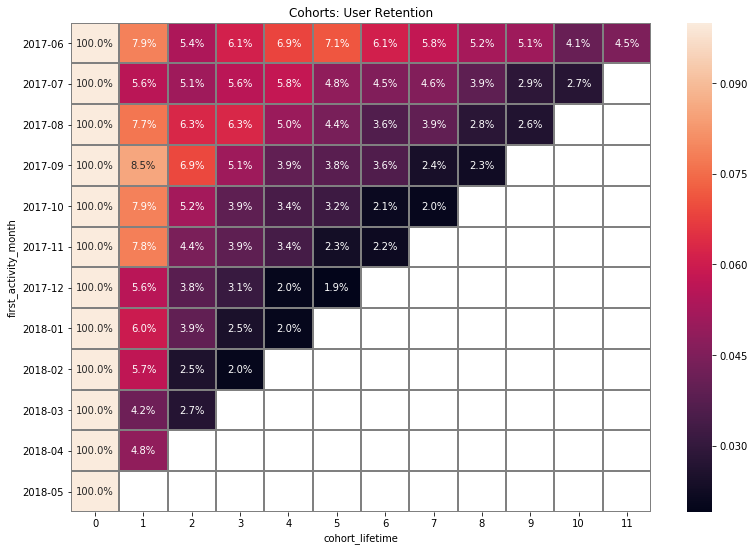

In [26]:
first_activity_month = visits.groupby(['uid'])['activity_month'].min()
first_activity_month.name = 'first_activity_month'

user_activity = visits.join(first_activity_month, on='uid')

user_activity['cohort_lifetime'] = ( 
    ((user_activity['activity_month'] - user_activity['first_activity_month'])
     / np.timedelta64(1, 'M'))
    .round()
    .astype('int')
)

cohorts = ( 
    user_activity.groupby(['first_activity_month', 'cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
)

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'uid']
]

initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 

#cohorts_split = cohorts[cohorts['cohort_lifetime']!=0]
cohorts_new = cohorts
cohorts_new['first_activity_month'] = cohorts_new['first_activity_month'].dt.strftime('%Y-%m')

retention_pivot = cohorts_new.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax = 0.1)
plt.show()

In [27]:
retantion_mean_second_month = cohorts.query('cohort_lifetime==1')['retention'].mean()
print('Средний Retantion Rate для второго месяца жизни когорт {:.2%}'.format(retantion_mean_second_month))

Средний Retantion Rate для второго месяца жизни когорт 6.52%


На тепловой карте кагортного анализа мы видим, что лишь малая доля тех, кто воспользовался сервисом в первом месяце, возвращается за его услугами во втором и последующих периодах. Во втором месяце жизни когорты в среднем только 6,52% пользователей когорт возвращаются за услугами снова. 

О проблемах с сервисом здесь говорить рано. Это скорее специфика услуги - нормально, что люди покупают билеты на мероприятия не каждый месяц. 

Однако стоит отметить, что заметно падение Retantion Rate. Этот показатель снижается от кагорты к кагорте. Здесь стоит изучить, почему удержание для новых кагорт падает с каждым разом. 

## Анализ метрик электронной коммерции

### Среднее время покупки

Рассчитаем дату и время первого визита и первой покупки для каждого пользователя. Рассчитаем между ними разницу. 

In [28]:
purchase_time = visits.groupby('uid')['start_ts'].min().reset_index()
purchase_time = purchase_time.rename(columns = {'start_ts':'first_visit'})

first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders = first_orders.rename(columns = {'buy_ts':'first_order'})

In [29]:
purchase_time = purchase_time.merge(first_orders, on = 'uid')

In [30]:
purchase_time['purchase_time'] = (purchase_time['first_order']-purchase_time['first_visit'])

In [31]:
purchase_time[purchase_time['purchase_time']=='0 days'].shape[0]

2455

Мы рассчитали время между первым визитом и первой покупкой для каждого пользователя. У 2455 пользователей значения оказались нулевыми. Такого быть не может, т.к. в учёт мы брали минуты и секунды. О проблеме с данными расскажем разработчикам, а данные с нулевыми значениями исключим из анализа, т.к. они могут сильно повлиять на результаты. 

In [32]:
purchase_time[~(purchase_time['purchase_time']=='0 days')]['purchase_time'].mean()

Timedelta('18 days 02:54:56.255613')

В среднем пользователи делают первые покупки на 18 день знакомства с сервисом. Возможно им нужно время, чтобы определить мероприятие, куда пойти. 

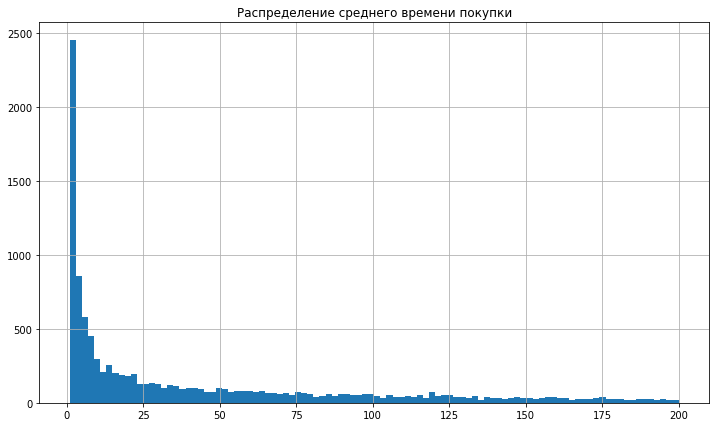

In [33]:
(purchase_time[~(purchase_time['purchase_time']=='0 days')]['purchase_time']
 /np.timedelta64(1,"D")).round().hist(figsize=(12,7), range=(1,200), bins=(100))
plt.title('Распределение среднего времени покупки')
plt.show()

In [34]:
purchase_time[~(purchase_time['purchase_time']=='0 days')]['purchase_time'].median()

Timedelta('0 days 00:21:00')

<div class="alert alert-info">
Медианное время покупки на сайте 21 минута. Примерно столько нужно времени на выбор и покупку билетов. 
</div>

###  Cреднее количество покупок

#### Посчитаем среднее количество покупок по когортам и месяцам

Подсчитаем Lifetime для каждой покупки. Построим тепловую карту когортного анализа. 

In [35]:
orders['month_order'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid')['month_order'].min().reset_index()
first_orders = first_orders.rename(columns = {'month_order':'first_order'})

In [36]:
orders = orders.merge(first_orders, on='uid')
orders['lifetime'] = (
    ((orders['month_order']-orders['first_order'])/np.timedelta64(1,'M'))
    .round()
    .astype('int')
)
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')

In [37]:
orders_cohort = orders.groupby(['first_order_month', 'lifetime']).agg({'uid':['count','nunique']}).reset_index()
orders_cohort.columns = ['first_order_month', 'lifetime', 'count_purchase', 'users']

In [38]:
orders_cohort['purchase_per_user'] = orders_cohort['count_purchase']/orders_cohort['users']

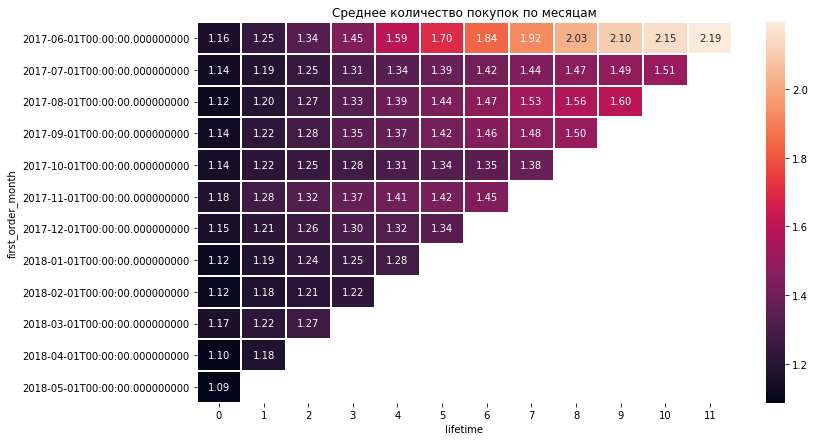

In [40]:
n_users_in_first_cohort = orders_cohort[orders_cohort['lifetime']==0][['first_order_month','users']]
n_users_in_first_cohort=n_users_in_first_cohort.rename(columns={'users':'first_users'})
bill_data = orders_cohort.merge(n_users_in_first_cohort, on = 'first_order_month')
bill_data['purchase_per_first_cohort'] = bill_data['count_purchase']/bill_data['first_users']

bill_pivot = (bill_data
                .pivot_table(
                    index = 'first_order_month', 
                    columns ='lifetime', 
                    values = 'purchase_per_first_cohort', 
                    aggfunc ='sum')
               )

bill_pivot = bill_pivot.cumsum(axis=1)
plt.figure(figsize=(12,7))
plt.title('Среднее количество покупок по месяцам')
sns.heatmap(bill_pivot, annot = True, fmt='.2f', linewidths = 1, linecolor = 'white')
plt.show()

<div class="alert alert-info">
Среднее количество покупок по когортам отличается слабо. Можно отметить июньскую когорту, где количество покупок на категорию растет быстрее обычного. Также выделяются августовская, сентябрьская и ноябрьская когорта, однако не так сильно как первая. Эти когорты можно стимулировать к повторным покупкам. 
</div>

#### Оценим среднее количество покупок за 6 месяцев

Также посчитаем, сколько в среднем было заказов на 1 пользователя за 6 самых популярных месяцев - с сентября по февраль. 

In [41]:
orders_mean = (
    orders.query('"2017-09-01" <= buy_ts < "2018-03-01"')['uid'].count()
    /orders.query('"2017-09-01" <= buy_ts < "2018-03-01"')['uid'].nunique()
)
orders_mean

1.3443826570510036

В среднем в популярные месяцы пользователи 1,34 раза делали покупки на сервисе. Нужно как-то убеждать пользовать вести активную жизнь, а не только сидеть в баре с друзьми. 

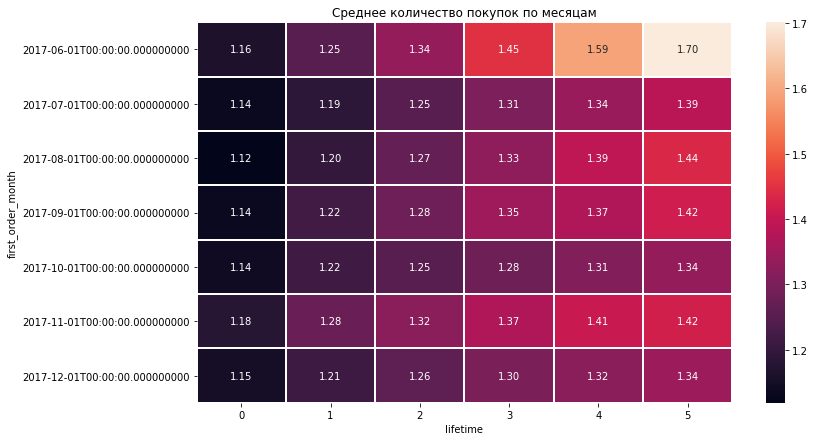

In [42]:
bill_data_split = bill_data[(bill_data['lifetime']<6)&(bill_data['first_order_month']<'2018-01-01')]

bill_split_pivot = (bill_data_split
                .pivot_table(
                    index = 'first_order_month', 
                    columns ='lifetime', 
                    values = 'purchase_per_first_cohort', 
                    aggfunc ='sum')
               )

bill_split_pivot = bill_split_pivot.cumsum(axis=1)
plt.figure(figsize=(12,7))
plt.title('Среднее количество покупок по месяцам')
sns.heatmap(bill_split_pivot, annot = True, fmt='.2f', linewidths = 1, linecolor = 'white')
plt.show()

In [43]:
bill_split_pivot.mean(axis=0)

lifetime
0    1.147361
1    1.223705
2    1.282533
3    1.340978
4    1.391329
5    1.434191
dtype: float64

<div class="alert alert-info">
Среднее количество покупок за первые 6 месяцев по всем когортам - 1,43. Показатель изменился, но не сильно. Нужно стимулировать людей вести активную жизнь. 
</div>

### Средний чек покупки

Посчитаем средний чек за всё время и покажем изменение среднего чека по дням. 


Средний чек за всё время 4.999678263974293



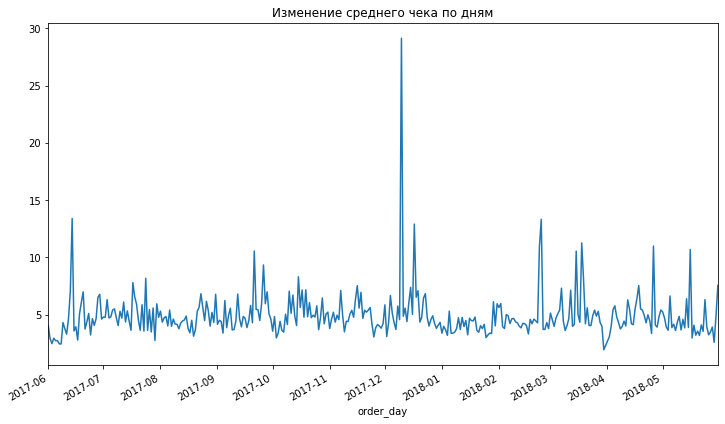

In [44]:
mean_revenue = orders['revenue'].mean()
print()
print('Средний чек за всё время', mean_revenue)
print ()

orders['order_day'] = orders['buy_ts'].astype('datetime64[D]')
orders.groupby('order_day')['revenue'].mean().plot(kind='line', figsize =(12,7))
plt.title('Изменение среднего чека по дням')
plt.show()


Средний чек за всё время около 5 у.е. На протяжении всего времени график колеблется вокург этой цифры. Есть выбросы, которые значительно превышают среднее. Как правило это однодневные выбросы. Их можно объяснить разными факторами - открытием продаж билетов с высокой ценой, покупкой большого количества билетов одними пользователями, обоими факторами вместе. 

### Изменение LTV на покупателя по когортам

Посчитаем LTV по всем когортам. Маржинальность сервиса 100%, поэтому валовую прибыль отдельно считать не будем. 

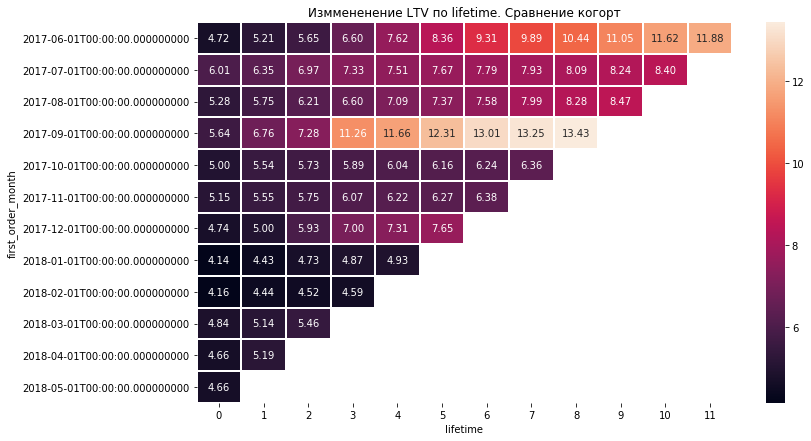

In [45]:
cohort_sizes = (
        orders.groupby('first_order_month')
        .agg({'uid':'nunique'})
        .reset_index()
    )
cohort_sizes.columns = ['first_order_month', 'n_buyers']

revenue_cohorts = (
    orders.groupby(['first_order_month', 'lifetime'])
    .agg({'revenue':'sum'})
    .reset_index()
                  )

ltv_cohorts = pd.merge(revenue_cohorts, cohort_sizes, on = 'first_order_month')

ltv_cohorts['ltv'] = ltv_cohorts['revenue']/ltv_cohorts['n_buyers']

output = ltv_cohorts.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'ltv', aggfunc = 'sum').round(2)
output = output.cumsum(axis=1)

plt.figure(figsize=(12,7))
plt.title('Изммененение LTV по lifetime. Сравнение когорт')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor = 'white')
plt.show()

Мы посчитали LTV по каждой когорте в разрезе времени их жизни. В среднем клиенты больше всего приносят денег в первый месяц пользования сервисом. 

<div class="alert alert-info">
Снова выделяется первая когорта. LTV  быстро накапливается ещё в сентябрьской когорте. <br>
<br> 
Несмотря на то, что посещаемость сервиса летом низкая, когорты, привлеченные в этот период, показывают хороший LTV. Проигрывают по этому показателю когорты, привлеченные после нового года. 
</div>

                         ltv
first_order_month           
2017-06-01          8.360084
2017-07-01          7.660775
2017-08-01          7.375861
2017-09-01         12.306463
2017-10-01          6.159956
2017-11-01          6.280316
2017-12-01          7.639913


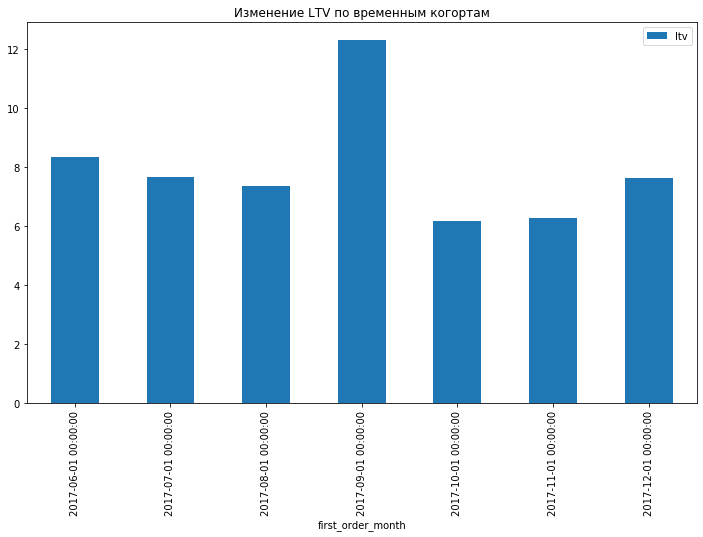

In [46]:
sum_ltv_cohorts = ltv_cohorts[(ltv_cohorts['lifetime'].isin(list(range(0,6))))&(ltv_cohorts['first_order_month']<'2018-01-01')]


sum_ltv_cohorts = sum_ltv_cohorts.pivot_table(index = 'first_order_month', values = 'ltv', aggfunc = 'sum')


print(sum_ltv_cohorts)
sum_ltv_cohorts.plot(kind='bar', figsize=(12,7))
plt.title('Изменение LTV по временным когортам')
plt.show()

Максимальный LTV показывает сентябрьская когорта. Похоже в тот период проходила крайне удачная акция, которая привлекла клиентов, заинтересованных в регулярном использовании сервиса. Нужно подробнее изучить канал, откуда эти клиенты пришли и изучить социально-демографические характеристики этой когорты. 

## Анализ маркетинговых метрик

### Распределение затрат на маркетинг по источникам

In [47]:
print('За весь период потратили на маркетинг ',costs['costs'].sum())
print()

За весь период потратили на маркетинг  329131.62



In [48]:
print()
print()

cost_per_source = costs.groupby('source_id')['costs'].sum().sort_values(ascending=False).reset_index()
print('Рейтинг источников по расходам за весь период')
print()
print(cost_per_source)



Рейтинг источников по расходам за весь период

   source_id      costs
0          3  141321.63
1          4   61073.60
2          5   51757.10
3          2   42806.04
4          1   20833.27
5         10    5822.49
6          9    5517.49


По источникам 6-8 за наблюдаемый период не было затрат. В дальнейшем не будем учитывать их при анализе. 

In [49]:
#plt.colormaps() 

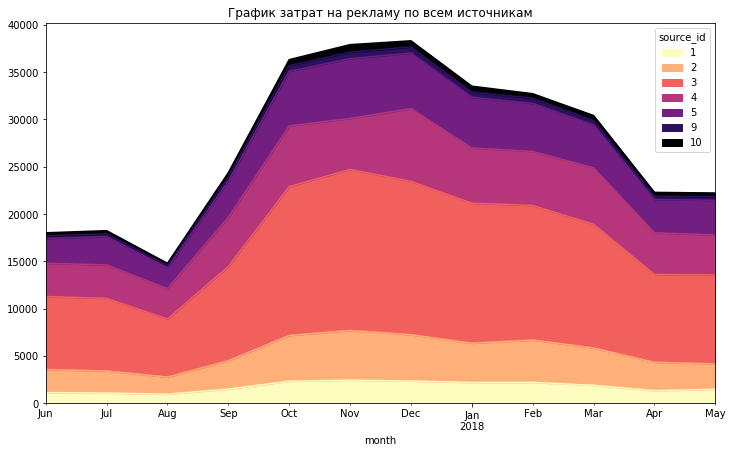

In [50]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index= 'month', columns = 'source_id', values = "costs", aggfunc='sum').plot.area(colormap = 'magma_r',figsize = (12,7), sort_columns = True)
plt.title('График затрат на рекламу по всем источникам')
plt.show()

В лидерах по затратам рекламный источник 3. Далее идут группой источники 4, 5, 2. На графике видим, что расходы увеличивались с августа 2017, достигли пика в ноябре-декабре и снизились к апрелю. 

### Расчёт стоимости привлечения клиента

#### Средняяя стоимость привлечения клиента за год

In [51]:
year_cac = (costs["costs"].sum()/orders['uid'].nunique()).round(2)
print('Средняя стоимость привлечения одного покупателя в год', year_cac, 'у.е.')

Средняя стоимость привлечения одного покупателя в год 9.01 у.е.


<div class="alert alert-success">
<b>Комментарий ревьюера: </b> Расчеты верны.  </div>

#### Средняя стоимость привлечения клиента по каждому источнику. 

Объединим данные об источниках визитов с совершенными заказами. 

In [52]:
orders = orders.rename(columns={'order_day':'activity_day'})
orders.shape

(50414, 8)

In [53]:
first_order_day = orders.groupby('uid')['buy_ts'].min().reset_index().rename(columns ={'buy_ts':'first_order_day'})
orders = orders.merge(first_order_day, on = 'uid')

<div class="alert alert-info">
    Вычислим первый источник перехода для каждого пользователя. 
    </div>

In [54]:
first_source = visits.sort_values(by = 'start_ts', ascending = True).groupby('uid')['source_id'].first()
first_source.name = 'first_source_id'
first_source2 = first_source
first_source = visits.join(first_source, on='uid')

<div class="alert alert-info">
Объединим таблицы по uid. У всех покупок будет первый источник перехода. Lifetime рассчитаем заново, т.к. у нас есть пользователи, для которых время между первым визитом и покупкой больше месяца. 

</div>

In [55]:
source_and_orders = (
    orders.merge(
        first_source, on = ['uid'])   
)

first_visit = source_and_orders.groupby('uid')['start_ts'].min()
first_visit.name = 'first_activity_date'
source_and_orders = source_and_orders.join(first_visit, on = 'uid')
source_and_orders['first_activity_month'] = source_and_orders['first_activity_date'].astype('datetime64[M]')

#source_and_orders = source_and_orders.rename(columns = {'activity_month':'first_activity_month'})
source_and_orders['lifetime'] = (
    ((source_and_orders['buy_ts']-source_and_orders['first_order_day'])/np.timedelta64(1, 'M'))
    .round().astype('int')
)


In [56]:
source_and_orders_unique = source_and_orders.sort_values('buy_ts').drop_duplicates('uid')

Посчитаем, сколько уникальных покупателей было по каждому источнику. 

In [57]:
source_users = source_and_orders_unique.groupby(['first_source_id', 'first_order_month'])['uid'].nunique().reset_index()
source_users = source_users.rename(columns = {'uid':'n_users'})
source_users.head(20)

,first_source_id,first_order_month,n_users
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
5,1,2017-11-01,324
6,1,2017-12-01,331
7,1,2018-01-01,238
8,1,2018-02-01,275
9,1,2018-03-01,281


Объединим данные о затраченных деньгах по источникам и количестве привлеченных пользователей. 

In [58]:
cost_per_source_and_month = costs.groupby(['source_id','month'])['costs'].sum().reset_index()
cost_per_source_and_month = cost_per_source_and_month.rename(columns = {'source_id':'first_source_id','month':'first_order_month'})

In [59]:
cac_per_sources = cost_per_source_and_month.merge(source_users, on = ['first_source_id', 'first_order_month'])
cac_per_sources = cac_per_sources.rename(columns = {'first_source_id':'source_id'} )

In [60]:
cac_per_sources['cac'] = cac_per_sources['costs']/cac_per_sources['n_users']

In [61]:
cac_per_month_and_source = cac_per_sources
cac_per_month_and_source = cac_per_month_and_source.rename(columns = {'first_order_month':'month'}) 

На источник 3 потратили больше всего бюджета, но он всё равно уступают источнику 4 по количеству привлеченных клиентов. Также по этому источнику самая дорогая стоимость привлечения клиента. Необходимо проверить, сколько денег приносят клиенты из этой рекламной кампании.

#### CAC по источникам в разрезе времени

Рассчитаем, сколько по каждому источнику тратили в месяц. 

In [68]:
cac_per_month_and_source_visual = cac_per_month_and_source

In [69]:
cost_per_source_and_month

,first_source_id,first_order_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


In [70]:
cac_per_month_and_source_visual['month'] = cac_per_month_and_source_visual['month'].dt.strftime('%Y-%m')

In [71]:
cost_per_source_and_month

,first_source_id,first_order_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
...,...,...,...
79,10,2018-01-01,614.35
80,10,2018-02-01,480.88
81,10,2018-03-01,526.41
82,10,2018-04-01,388.25


Построим сводную таблицу. 

In [72]:
cac_pivot = cac_per_month_and_source_visual.pivot_table(index='source_id', columns='month', values='cac', aggfunc='sum')

Визуализируем таблицу.

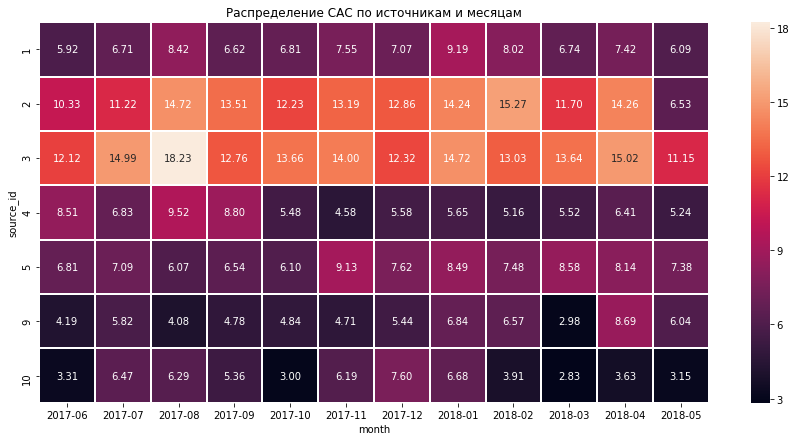

In [73]:
plt.figure(figsize=(15,7))
plt.title('Распределение CAC по источникам и месяцам')
sns.heatmap(cac_pivot, annot = True, fmt='.2f', linewidths = 1, linecolor = 'white')
plt.show()

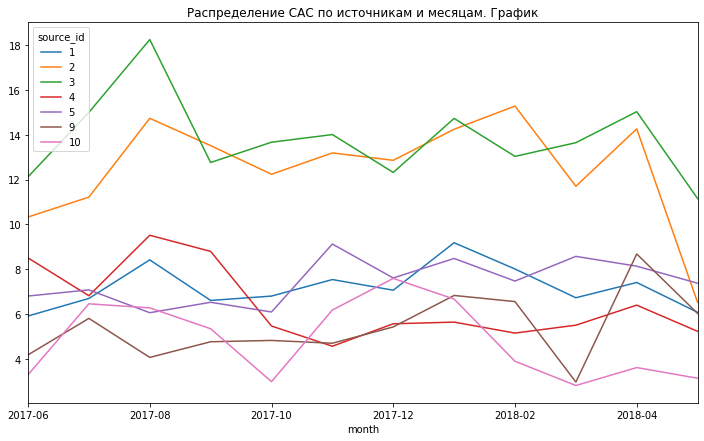

In [74]:
cac_per_month_and_source.pivot_table(index='month', columns='source_id', values='cac', aggfunc='sum').plot(figsize=(12,7))
plt.title('Распределение CAC по источникам и месяцам. График')
plt.show()

Видим, что CAC по 3 источнику самый дорогой на протяжении всего года. Далее идёт источник 2. Источник 9 имеет тендеции к увеличению CAC. В апреле этот показатель сильно увеличился и превысил CAC 3 источника, однако возможно мы имеет дело с ошибкойй в данных. Нужно изучить данные за этот месяц по 9 источнику. 

In [76]:
source_and_orders = source_and_orders[
    ['first_source_id','start_ts', 'first_activity_month', 'first_order_month', 'uid', 'buy_ts','revenue', 'month_order','lifetime']
]

### Рассчёт ROMI

Посчитаем LTV по когортам в разрезе источников. 

На протяжении всего жизненного пути один клиент мог переходить из разных источников. Однако правильнее будет включать такого пользователя в кагорту с первым источником, откуда он перешёл на сайт. Определим первый источник для каждого пользователя. 

In [79]:
first_source2

uid
11863502262781          3
49537067089222          2
297729379853735         3
313578113262317         2
325320750514679         5
                       ..
18446403737806311543    5
18446424184725333426    4
18446556406699109058    3
18446621818809592527    4
18446676030785672386    3
Name: first_source_id, Length: 228169, dtype: int64

Мы добавили первый источник перехода в нашу таблицу с заказами. Теперь посчитаем, сколько прибыли принесла каждая временная когорта за каждый месяц.

In [80]:
orders = orders.join(first_source2, on='uid')

In [81]:
revenue_per_sources = (
    orders
    .groupby(
        ['first_source_id',
         'first_order_month', 
         'lifetime'])
    ['revenue'].sum()
    .reset_index()
)

In [82]:
revenue_per_sources = revenue_per_sources.rename(columns = {'first_source_id':'source_id'})

Добавим к этой таблице данные о затратах на привлечение клиента и количестве уникальных пользователей.

In [83]:
revenue_per_sources = revenue_per_sources.rename(columns={'first_order_month':'month'})
revenue_per_sources.head(20)

,source_id,month,lifetime,revenue
0,1,2017-06-01,0,1378.70
1,1,2017-06-01,1,414.98
2,1,2017-06-01,2,419.43
3,1,2017-06-01,3,714.24
4,1,2017-06-01,4,811.20
5,1,2017-06-01,5,389.34
6,1,2017-06-01,6,490.48
7,1,2017-06-01,7,479.23
8,1,2017-06-01,8,432.15
9,1,2017-06-01,9,316.30


In [84]:
cac_per_month_and_source['month'] = cac_per_month_and_source['month'].astype('datetime64[M]')
cac_per_month_and_source

,source_id,month,costs,n_users,cac
0,1,2017-06-01,1125.61,190,5.924263
1,1,2017-07-01,1072.88,160,6.705500
2,1,2017-08-01,951.81,113,8.423097
3,1,2017-09-01,1502.01,227,6.616784
4,1,2017-10-01,2315.75,340,6.811029
...,...,...,...,...,...
79,10,2018-01-01,614.35,92,6.677717
80,10,2018-02-01,480.88,123,3.909593
81,10,2018-03-01,526.41,186,2.830161
82,10,2018-04-01,388.25,107,3.628505


In [85]:

sorces_and_time_data = revenue_per_sources.merge(cac_per_month_and_source, on=['source_id', 'month'])
sorces_and_time_data.head(20)

,source_id,month,lifetime,revenue,costs,n_users,cac
0,1,2017-06-01,0,1378.70,1125.61,190,5.924263
1,1,2017-06-01,1,414.98,1125.61,190,5.924263
2,1,2017-06-01,2,419.43,1125.61,190,5.924263
3,1,2017-06-01,3,714.24,1125.61,190,5.924263
4,1,2017-06-01,4,811.20,1125.61,190,5.924263
5,1,2017-06-01,5,389.34,1125.61,190,5.924263
6,1,2017-06-01,6,490.48,1125.61,190,5.924263
7,1,2017-06-01,7,479.23,1125.61,190,5.924263
8,1,2017-06-01,8,432.15,1125.61,190,5.924263
9,1,2017-06-01,9,316.30,1125.61,190,5.924263


Рассчитаем LTV для каждой строчки. 

In [86]:
sorces_and_time_data['ltv'] = sorces_and_time_data['revenue'] /sorces_and_time_data['n_users']
sorces_and_time_data.head(20)

,source_id,month,lifetime,revenue,costs,n_users,cac,ltv
0,1,2017-06-01,0,1378.70,1125.61,190,5.924263,7.256316
1,1,2017-06-01,1,414.98,1125.61,190,5.924263,2.184105
2,1,2017-06-01,2,419.43,1125.61,190,5.924263,2.207526
3,1,2017-06-01,3,714.24,1125.61,190,5.924263,3.759158
4,1,2017-06-01,4,811.20,1125.61,190,5.924263,4.269474
5,1,2017-06-01,5,389.34,1125.61,190,5.924263,2.049158
6,1,2017-06-01,6,490.48,1125.61,190,5.924263,2.581474
7,1,2017-06-01,7,479.23,1125.61,190,5.924263,2.522263
8,1,2017-06-01,8,432.15,1125.61,190,5.924263,2.274474
9,1,2017-06-01,9,316.30,1125.61,190,5.924263,1.664737


Расссчитаем ROMI.

In [87]:
sorces_and_time_data['romi'] = sorces_and_time_data['ltv']/sorces_and_time_data['cac']

In [88]:
sorces_and_time_data

,source_id,month,lifetime,revenue,costs,n_users,cac,ltv,romi
0,1,2017-06-01,0,1378.70,1125.61,190,5.924263,7.256316,1.224847
1,1,2017-06-01,1,414.98,1125.61,190,5.924263,2.184105,0.368671
2,1,2017-06-01,2,419.43,1125.61,190,5.924263,2.207526,0.372625
3,1,2017-06-01,3,714.24,1125.61,190,5.924263,3.759158,0.634536
4,1,2017-06-01,4,811.20,1125.61,190,5.924263,4.269474,0.720676
...,...,...,...,...,...,...,...,...,...
509,10,2018-03-01,0,638.44,526.41,186,2.830161,3.432473,1.212819
510,10,2018-03-01,1,12.71,526.41,186,2.830161,0.068333,0.024145
511,10,2018-03-01,2,6.29,526.41,186,2.830161,0.033817,0.011949
512,10,2018-04-01,0,261.93,388.25,107,3.628505,2.447944,0.674643


Создадим функцию, чтобы составить сводные таблицы и визуализировать их по каждому из источников.  

В данных имеется проблема - клиенты из каждой когорты совершали покупки не каждый месяц. В данных имется пропуски, что помешает посчитать кумулятивную сумму.Если заполнить пропуски нулями, то будет не видно, где заканчивается возраст когорты. Чтобы данные были актуальными, измерим только те когорты, где есть данные о 6 месяцах её жизни. 

In [89]:
def pivot_romi(source, age): 
    data = sorces_and_time_data[sorces_and_time_data['source_id']==source]
    pivot_data = data.pivot_table(index='month', columns = 'lifetime', values ='romi', aggfunc = 'mean')
    pivot_data = pivot_data.cumsum(axis=1).round(2)
    title = 'Окупаемость инвестиций по источнику {}'.format(source)
    
    print(title, '. Средняя по всем когортам')
    print(pivot_data.mean(axis=0))
    print()
    
    plt.figure(figsize=(12, 7))
    plt.title(title)
    return sns.heatmap(pivot_data, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmax=1)

Окупаемость инвестиций по источнику 1 . Средняя по всем когортам
lifetime
0     0.892500
1     1.048182
2     1.258000
3     1.363333
4     1.565000
5     1.770000
6     2.038333
7     2.362000
8     2.860000
9     3.463333
10    4.260000
11    5.680000
dtype: float64

Окупаемость инвестиций по источнику 2 . Средняя по всем когортам
lifetime
0     0.549167
1     0.630909
2     0.777000
3     0.938889
4     1.085000
5     1.228571
6     1.031667
7     1.142000
8     1.217500
9     0.993333
10    1.290000
11    1.610000
dtype: float64

Окупаемость инвестиций по источнику 3 . Средняя по всем когортам
lifetime
0     0.336667
1     0.357273
2     0.366000
3     0.381111
4     0.396250
5     0.411429
6     0.421667
7     0.444000
8     0.452500
9     0.433333
10    0.480000
11    0.470000
dtype: float64

Окупаемость инвестиций по источнику 4 . Средняя по всем когортам
lifetime
0     0.756667
1     0.774545
2     0.791000
3     0.815556
4     0.842500
5     0.901429
6     0.981667
7     0.900

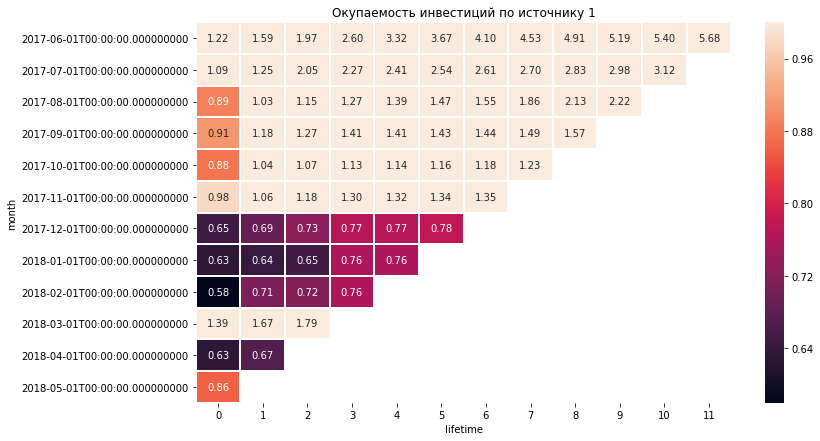

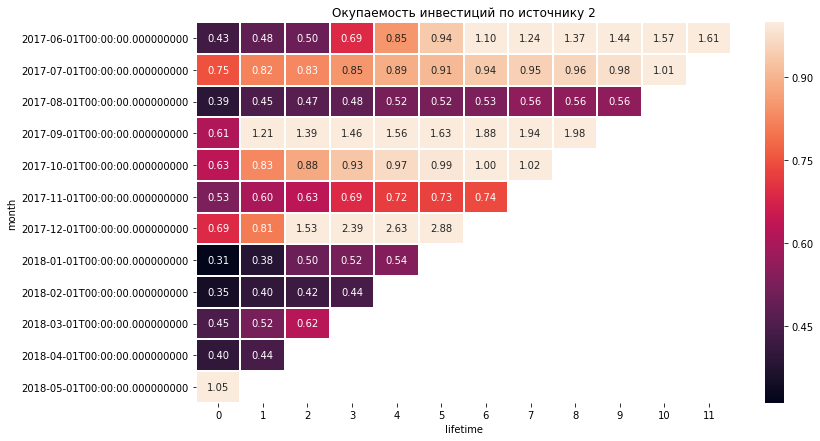

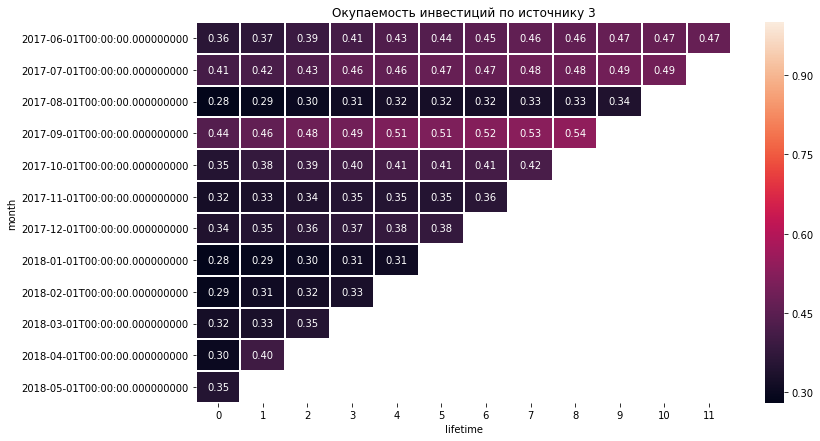

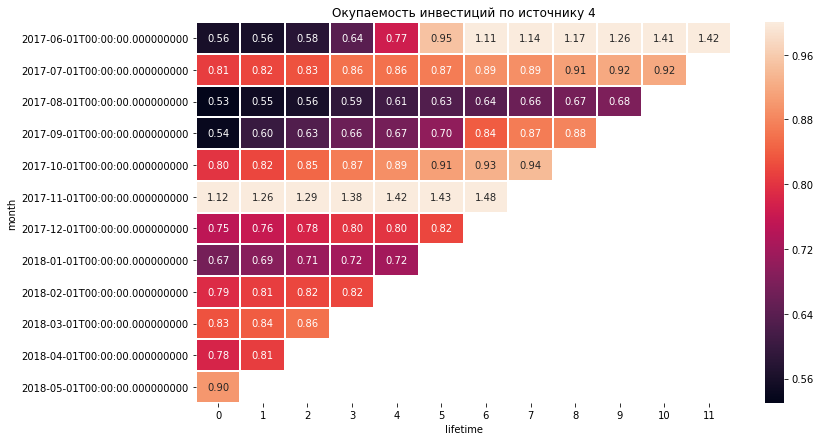

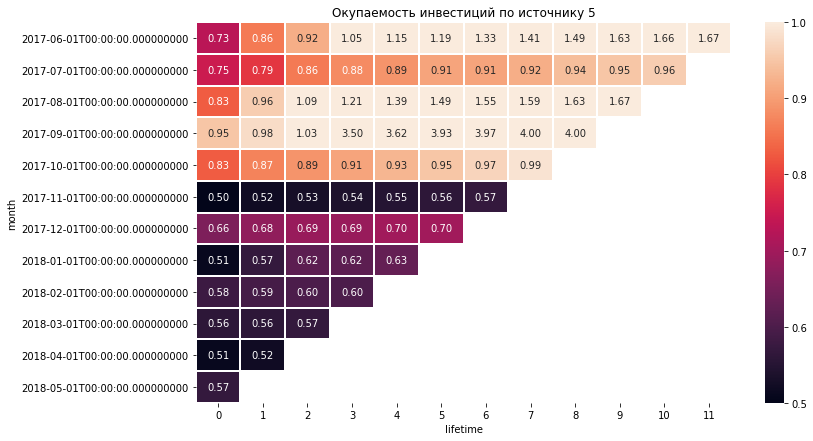

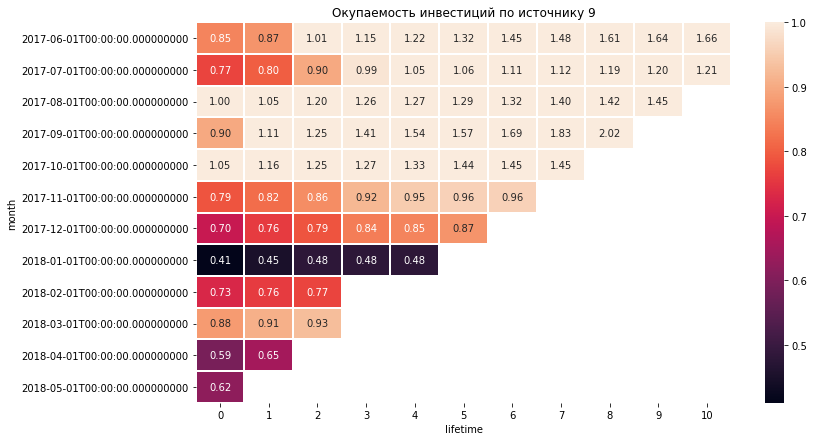

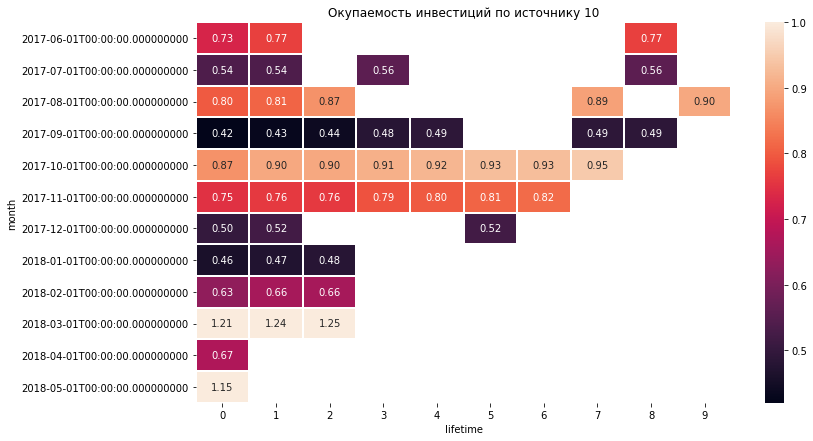

In [90]:
sorces = [1,2,3,4,5,9,10]
for i in sorces:
    pivot_romi(i, 6)

<div class="alert alert-info">

За год инвестиции окупаются по всем источникам, кроме 3. В зависимости от целей на этот источник, нужно принять решение об его оптимизации. Лучший траифк всё так же из первого источника. Во 2 источнике при дорогом CAC получается хороший ROMI - к концу года инвестиции окупаются в 3 раза. В 3 раза окупаются инвестиции и из 9 источника, при этом затраты на него небольшие.  По источникам 5 и 4 инвестиции окупаются к концу года в 2 раза. По источнику 10 просто окупаются. <br>
<br>
<br>Если 3 источник - таргетированная реклама либо медийка, то не трогаем его. Если нет, то оптимизируем. 
<br>
    Увеличиваем бюджет по источнику 1. Следим как изменится стоимость привлечения. Скорее всего это органика. Платим больше CEO-специалистам, всегда есть куда расти. <br>
<br>
    Источник 2 не трогаем. <br>
    <br>
    По источнику 9 увеличиваем бюджет. <br>
    <br>
    5 и 4 оптимизируем.<br>
    <br>
    10 не трогаем - в минус он не работает, в будущем возможно принесет прибыль. <br>
    <br>
    Также можно отметить закономерность, что летние и осенние кагорты во всех источниках окупаются быстрее, чем зимние и весенние. 
 </div>

Выше проверял окупаемость инвестиций по всем источникам за 12 месяцев. Увеличение срока результатов не дало - инвестиции по всем источникам не окупаются в ближайший год. Было только 1 исключение в 10 источнике августовской когорты - здесь инвестиции окупились в 1 месяце, но это скорее исключение. 

## Вывод

В ходе исследования мы прошли несколько этапов на пути к получению полной картинки использования сервиса. Мы исследовали посещаемость сайта в разные временные интервалы, рассчитали retantion rate, среднее время покупки, среднее количество покупок, средний чек, LTV, CAC, ROMI. На основании полученных данных мы подготовили выводи и рекомендации, которые должны помочь в развитии сервиса. <br>  
<br>
<b>Продуктовый анализ</b><br>
Изучив использование продукта во времени мы обнаружили несколько зависимостей. Посещаемость сервиса увеличивается в холодное время года - осенью, зимой, в начале весны. Это связано с тем, что лето является сезоном отпусков, в это время проводится меньше концертов, выстовок и других мероприятий. Однако не стоит сбрасывать этот сезон со счетов. Летом проводится много уличных фестивалей - можно выделить бюджет на продвижение этих мероприятий. <br>
<br>
Также мы выявили зависимость посещаемости от дней недели. Самый активный день покупки билетов - четверг, в этот день нужно покупать боьше трафика и повышать ставки на рекламных аукционах. Далее идут понедельник и пятница. В понедельник люди под впечатлением от прошедших выходных видимо хотят продолжить веселье и на следующих выходных (во вторник и среду энтузиазм постепенно снижается). В пятницу же приходят те, кто хочет успеть в уходящий поезд. На эти группы людей тоже стоит выделить достаточное количество трафика. На выходные же нужно выделить бюджет по остаточному принципу. <br>
<br>
На дневном графике посещаемости сайта мы выявили сильные выбросы. Скорее всего это связано с началом продажи билетов на особо популярные события. Нужно выявить какие, чтобы в будущем выделять на аналогичные больше рекламного бюджета для привлечения клиентов. <br>
<br>
Sticky factor сервиса низкий. 3,81% для отношения дневной активности к месячной. Это означает, что лишь маленький процент используют сервис регулярно. Нужно стараться привлекать в сервис аудиторию, кто покупает билеты регулярно - постоянно ходят в кино, на концерты и выставки. Также можно разбавлять предоставляемые услуги подборкой небольших мероприятий с низкой стоимостью или  бесплатной регистрацией. <br>
<br>
Мода времени посещения сайта равна одной минуте. Скорее всего это визиты с таргетированной рекламы и медийки - люди увидели рекламу концерта, зашли посмотреть, пролистали страницу за минуту и ушли думать. В среднем же посетители проводят 11 минут на сайте. <br>
<br>
Retantion Rate резко падает уже на второй месяц использования сервиса когортой (6,52%). Лишь малая часть привлеченных клиентов возвращается в сервис повторно. Нужно что-то делать с удержанием. Как уже писалось выше, добавлять мероприятия, куда пользователь может ходить каждую неделю.<br>
<br>
<br>
<b>Анализ метрик электронной коммерции</b><br>
<br>Среднее время покупки билета составляет 18 дней с первого визита. Это означает, что нужно собирать базу ретаргетинга и начинать стимулировать к покупке пользователей примерно через 2 недели после первого просмотра пользователем мероприятия.<br>
<br>
Среднее количество покупок растёт после первого месяца использования сервиса. Видимо остаются те, кто регулярно ходит на мероприятия и покупают билеты несколько раз в месяц. Особенно активная когорта пользователей, пришедших впервые на сервис в июне 2017. Нужно изучить её источник и маркетинговые мероприятия, проводившиеся в тот период. <br>
<br>
В среднем же пользователи делают покупки 1,34 раза за пол года в самый активный период. Нужно как то вытаскивать людей из квартир и баров, либо продавать и на эти мероприятия билеты. <br>
<br>
Средний чек на протяжении всего периода держится на одном уровне. Нужно проверить, с чем они связаны - очень дорогие билеты в чеке или большое количество билетов в одном чеке. Во втором случае нужно задуматься о проблеме с перекупщикамий билетов.<br>
<br>
LTV по всем когортам выше в первый месяц использования. Здесь можно повторить ранее озвученные предложения - стимулировать пользователей возвращаться. <br>
<br>
Лидирует по показателю LTV сентябрьская когорта (12,3 у.е) - больше половины LTV складывается из последущего периода. Нужно изучить, кого удалось привлечь в эту когорту. <br>
<br>
<br>
<b>Анализ маркетинговых метрик</b><br>
Как уже говорилось ранее, основную долю прибыли клиенты приносят в первый месяц использования сервиса. Далее ROMI практически не увеличивается и это относится ко всем источникам и всем временным когортам. <br>
<br>
В исследуемый период инвестиции окупились только по источнику 1 (инвестиции окупились в 50% когорт, средний ROMI на протяжении всего lifetime выше 1). Здесь можно постепенно увеличивать бюджет на продвижение, расширять аудиторию, следя, чтобы показатель не сильно падал. <br>
<br>
По затратам на маркетинг лидирует 3 источник трафика (141т. у.е.). При этом по нему самый низкий ROMI (31% за пол года). Если это не таргетированная реклама, то нужно задуматься о снижении расходов на этот источник и оптимизировать кампании. <br>
<br>
В кампаниях 4, 5, 2 нужно тоже поработать над окупаемостью инвестиций. За год по этим источникам ROMI колеблется от 50 до 70%. Нужно оптимизировать кампании для снижения CAC. <br>
<br>
Для кампании 9 работает небольшой бюджет. показатель ROMI 62%. Нужно попробовать оптимизировать кампании, попробовать рекламу на другой аудитоии. Возможно получится увеличить LTV клиентов. <br>
<br>
Клиенты с 10 источника приходят ещё реже. Есть когорта, где инвестиции сразу окупились. Нужно изучить её, попробовать найти похожую и рекламироваться на неё. 


<div class="alert alert-info">
Дополнительные выводы: 
- Клиенты, привлеченные летом и осенью приносят больше прибыли и быстрее окупаются. В эти периоды нужно активнее работать над привлечением новых клиентов.   <br>
    <br>
     По источникам: <br>
- Если 3 источник - таргетированная реклама либо медийка, то не трогаем его. Если нет, то оптимизируем. 
<br>
    - Увеличиваем бюджет по источнику 1. Следим как изменится стоимость привлечения. Скорее всего это органика. Платим больше CEO-специалистам, всегда есть куда расти. <br>
<br>
    - Источник 2 не трогаем. <br>
    <br>
    - По источнику 9 увеличиваем бюджет. <br>
    <br>
    - 5 и 4 оптимизируем.<br>
    <br>
    - 10 не трогаем - в минус он не работает, в будущем возможно принесет прибыль. <br>
    <br>
    
</div>